# Analyze Branching Soups

This notebook analyzes model soups created from branched finetuning variants.

**Hypothesis to Test:**
Early branching (high loss, high in loss landscape) → models end up in different basins → poor soup performance

Late branching (lower loss, models closer) → models end up in same basin → good soup performance

**Analysis:**
1. Load models from different branching epochs
2. Compute pairwise L2 distances between variants
3. Create uniform soups from variants at each branching point
4. Evaluate soup performance vs branching epoch
5. Visualize the basin transition hypothesis

## Setup Environment

In [1]:
LOCAL = False

if LOCAL:
    ROOT_DIR = "/Users/Yang/Desktop/research-model-merge/playground/merge_soup-resnet18-cifar10"
    DATA_DIR = "/Users/Yang/Desktop/research-model-merge/datasets"
    PROJECT_ROOT = "/Users/Yang/Desktop/research-model-merge"
else:
    # on Colab
    ROOT_DIR = "/content/research-model-merge/playground/merge_soup-resnet18-cifar10"
    DATA_DIR = "/content/research-model-merge/datasets"
    PROJECT_ROOT = "/content/research-model-merge"
    DRIVE_DIR = "/content/drive/MyDrive/research-model_merge-shared/merge_soup-resnet18-cifar10"

### Mount Google Drive (Colab only)

In [2]:
if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


### Clone Repository and Install Dependencies (Colab only)

In [3]:
if not LOCAL:
    !rm -rf research-model-merge
    !git clone https://github.com/nbzy1995/research-model-merge.git /content/research-model-merge
    !pip install --quiet --upgrade pip
    !pip install -q -r research-model-merge/requirements.txt
    print("✅ Repository cloned and dependencies installed!")

Cloning into '/content/research-model-merge'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 106 (delta 41), reused 100 (delta 35), pack-reused 0 (from 0)
Receiving objects: 100% (106/106), 1.56 MiB | 4.92 MiB/s, done.
Resolving deltas: 100% (41/41), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.0 MB/s eta 0:00:00
✅ Repository cloned and dependencies installed!


### Import Libraries

In [4]:
import os
import sys
import subprocess
from itertools import combinations

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Add project directories to path
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)

from datasets.cifar10 import CIFAR10
from utils import (
    create_cifar10_resnet18,
    load_checkpoint,
    evaluate_model,
    create_uniform_soup,
    compute_l2_distance
)

### Check Device Information

In [5]:
print("🔍 System Information:")
print(f"Python version: {subprocess.check_output(['python', '--version']).decode().strip()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
    DEVICE = torch.device("cuda")
else:
    if LOCAL:
        print("⚠️ No GPU available! Evaluation will be slow on CPU.")
    else:
        print("❌ No GPU available! Please enable GPU runtime in Colab.")
    DEVICE = torch.device("cpu")

🔍 System Information:
Python version: Python 3.12.12
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU device: Tesla T4
GPU memory: 15.8 GB
CUDA version: 12.6


## Prepare Dataset

In [6]:
dataset = CIFAR10(
    data_location=DATA_DIR,
    batch_size=256,
    num_workers=2
)

test_loader = dataset.test_loader

print(f"✅ Dataset loaded:")
print(f"   Test samples: {len(dataset.test_dataset)}")

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


✅ Dataset loaded:
   Test samples: 10000


## Analysis Configuration

In [7]:
# Match the configuration from training notebooks
BRANCHING_EPOCHS = [0, 2, 5, 8]
LR_VARIANTS = [1, 2, 3, 4, 5]  # lr_ids
BRANCH_EPOCHS = 10  # How many epochs were trained after branching

# Analysis epochs (which epoch after branching to analyze)
ANALYSIS_EPOCHS = [1, 5, 10]  # e.g., early, mid, final

if LOCAL:
    CHECKPOINT_DIR = f"{ROOT_DIR}/checkpoints"
    RESULTS_DIR = f"{ROOT_DIR}/results"
else:
    CHECKPOINT_DIR = f"{DRIVE_DIR}/checkpoints"
    RESULTS_DIR = f"{DRIVE_DIR}/results"

os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Analysis Configuration:")
print(f"  Branching Epochs: {BRANCHING_EPOCHS}")
print(f"  LR Variants: {LR_VARIANTS}")
print(f"  Analysis Epochs: {ANALYSIS_EPOCHS}")
print(f"  Results Dir: {RESULTS_DIR}")

Analysis Configuration:
  Branching Epochs: [0, 2, 5, 8]
  LR Variants: [1, 2, 3, 4, 5]
  Analysis Epochs: [1, 5, 10]
  Results Dir: /content/drive/MyDrive/research-model_merge-shared/merge_soup-resnet18-cifar10/results


## Load and Evaluate Individual Models

In [ ]:
criterion = nn.CrossEntropyLoss()
individual_results = []

print("Evaluating individual models...\n")

for branch_epoch in BRANCHING_EPOCHS:
    for lr_id in LR_VARIANTS:
        for analysis_epoch in ANALYSIS_EPOCHS:
            checkpoint_name = f"branch_e{branch_epoch}_lr{lr_id}_e{analysis_epoch}.pt"
            checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_name)

            if not os.path.exists(checkpoint_path):
                print(f"⚠️  Skipping missing: {checkpoint_name}")
                continue

            # Load model
            model = create_cifar10_resnet18()
            state_dict = load_checkpoint(checkpoint_path, device=DEVICE)
            model.load_state_dict(state_dict)
            model = model.to(DEVICE)

            # Evaluate
            test_loss, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)

            individual_results.append({
                'branch_epoch': branch_epoch,
                'lr_id': lr_id,
                'analysis_epoch': analysis_epoch,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'checkpoint_name': checkpoint_name
            })

            print(f"✓ {checkpoint_name}: {100*test_acc:.2f}%")

df_individual = pd.DataFrame(individual_results)
print(f"\n✅ Evaluated {len(individual_results)} individual models")

Evaluating individual models...

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


✓ branch_e0_lr1_e1.pt: 24.05%


✓ branch_e0_lr1_e5.pt: 53.87%


✓ branch_e0_lr1_e10.pt: 69.59%


✓ branch_e0_lr2_e1.pt: 67.98%


✓ branch_e0_lr2_e5.pt: 83.78%


✓ branch_e0_lr2_e10.pt: 87.80%


✓ branch_e0_lr3_e1.pt: 74.95%


✓ branch_e0_lr3_e5.pt: 87.69%


✓ branch_e0_lr3_e10.pt: 90.53%


✓ branch_e0_lr4_e1.pt: 74.16%


✓ branch_e0_lr4_e5.pt: 87.01%


✓ branch_e0_lr4_e10.pt: 90.09%


✓ branch_e0_lr5_e1.pt: 55.00%


✓ branch_e0_lr5_e5.pt: 77.56%


✓ branch_e0_lr5_e10.pt: 84.12%


✓ branch_e2_lr1_e1.pt: 49.97%


✓ branch_e2_lr1_e5.pt: 81.24%


✓ branch_e2_lr1_e10.pt: 86.62%


✓ branch_e2_lr2_e1.pt: 75.58%


✓ branch_e2_lr2_e5.pt: 88.96%


✓ branch_e2_lr2_e10.pt: 90.19%


✓ branch_e2_lr3_e1.pt: 85.20%


✓ branch_e2_lr3_e5.pt: 88.11%


✓ branch_e2_lr3_e10.pt: 90.70%


✓ branch_e2_lr4_e1.pt: 85.37%


✓ branch_e2_lr4_e5.pt: 88.32%


✓ branch_e2_lr4_e10.pt: 90.62%


✓ branch_e2_lr5_e1.pt: 85.75%


✓ branch_e2_lr5_e5.pt: 87.07%


✓ branch_e2_lr5_e10.pt: 88.12%


✓ branch_e5_lr1_e1.pt: 58.56%


✓ branch_e5_lr1_e5.pt: 82.17%


✓ branch_e5_lr1_e10.pt: 87.01%


✓ branch_e5_lr2_e1.pt: 76.55%


✓ branch_e5_lr2_e5.pt: 88.73%


✓ branch_e5_lr2_e10.pt: 90.69%


✓ branch_e5_lr3_e1.pt: 88.15%


✓ branch_e5_lr3_e5.pt: 88.58%


✓ branch_e5_lr3_e10.pt: 91.13%


✓ branch_e5_lr4_e1.pt: 89.79%


✓ branch_e5_lr4_e5.pt: 90.18%


✓ branch_e5_lr4_e10.pt: 91.39%


✓ branch_e5_lr5_e1.pt: 89.88%


✓ branch_e5_lr5_e5.pt: 90.35%


✓ branch_e5_lr5_e10.pt: 90.74%


✓ branch_e8_lr1_e1.pt: 35.65%


✓ branch_e8_lr1_e5.pt: 68.29%


✓ branch_e8_lr1_e10.pt: 78.88%


✓ branch_e8_lr2_e1.pt: 79.59%


✓ branch_e8_lr2_e5.pt: 89.35%


✓ branch_e8_lr2_e10.pt: 89.49%


✓ branch_e8_lr3_e1.pt: 88.17%


✓ branch_e8_lr3_e5.pt: 89.08%


✓ branch_e8_lr3_e10.pt: 91.28%


✓ branch_e8_lr4_e1.pt: 89.77%


✓ branch_e8_lr4_e5.pt: 90.35%


✓ branch_e8_lr4_e10.pt: 91.26%


✓ branch_e8_lr5_e1.pt: 90.50%


✓ branch_e8_lr5_e5.pt: 90.69%


✓ branch_e8_lr5_e10.pt: 90.81%

✅ Evaluated 60 individual models


## Compute Pairwise L2 Distances

In [ ]:
distance_results = []

print("Computing pairwise L2 distances...\n")

for branch_epoch in BRANCHING_EPOCHS:
    for analysis_epoch in ANALYSIS_EPOCHS:
        print(f"Branch epoch {branch_epoch}, analysis epoch {analysis_epoch}:")

        # Load all models for this configuration
        models_data = []
        for lr_id in LR_VARIANTS:
            checkpoint_name = f"branch_e{branch_epoch}_lr{lr_id}_e{analysis_epoch}.pt"
            checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_name)

            if not os.path.exists(checkpoint_path):
                continue

            state_dict = load_checkpoint(checkpoint_path, device='cpu')  # Load to CPU for distance computation
            models_data.append({
                'lr_id': lr_id,
                'state_dict': state_dict,
                'checkpoint_name': checkpoint_name
            })

        # Compute pairwise distances
        for i, j in combinations(range(len(models_data)), 2):
            model_i = models_data[i]
            model_j = models_data[j]

            l2_dist = compute_l2_distance(model_i['state_dict'], model_j['state_dict'])

            distance_results.append({
                'branch_epoch': branch_epoch,
                'analysis_epoch': analysis_epoch,
                'lr_id_1': model_i['lr_id'],
                'lr_id_2': model_j['lr_id'],
                'l2_distance': l2_dist
            })

        print(f"  Computed {len(list(combinations(range(len(models_data)), 2)))} pairwise distances")

df_distances = pd.DataFrame(distance_results)
print(f"\n✅ Computed {len(distance_results)} pairwise distances")

Computing pairwise L2 distances...

Branch epoch 0, analysis epoch 1:
  Computed 10 pairwise distances
Branch epoch 0, analysis epoch 5:
  Computed 10 pairwise distances
Branch epoch 0, analysis epoch 10:
  Computed 10 pairwise distances
Branch epoch 2, analysis epoch 1:
  Computed 10 pairwise distances
Branch epoch 2, analysis epoch 5:
  Computed 10 pairwise distances
Branch epoch 2, analysis epoch 10:
  Computed 10 pairwise distances
Branch epoch 5, analysis epoch 1:
  Computed 10 pairwise distances
Branch epoch 5, analysis epoch 5:
  Computed 10 pairwise distances
Branch epoch 5, analysis epoch 10:
  Computed 10 pairwise distances
Branch epoch 8, analysis epoch 1:
  Computed 10 pairwise distances
Branch epoch 8, analysis epoch 5:
  Computed 10 pairwise distances
Branch epoch 8, analysis epoch 10:
  Computed 10 pairwise distances

✅ Computed 120 pairwise distances


## Create and Evaluate Soups

In [ ]:
soup_results = []

print("Creating and evaluating soups...\n")

for branch_epoch in BRANCHING_EPOCHS:
    for analysis_epoch in ANALYSIS_EPOCHS:
        print(f"Creating soup: branch_e{branch_epoch}, analysis_e{analysis_epoch}")

        # Load all models for this configuration
        state_dicts = []
        for lr_id in LR_VARIANTS:
            checkpoint_name = f"branch_e{branch_epoch}_lr{lr_id}_e{analysis_epoch}.pt"
            checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_name)

            if not os.path.exists(checkpoint_path):
                continue

            state_dict = load_checkpoint(checkpoint_path, device='cpu')
            state_dicts.append(state_dict)

        if len(state_dicts) == 0:
            print(f"  ⚠️  No models found, skipping")
            continue

        # Create uniform soup
        soup_state_dict = create_uniform_soup(state_dicts)

        # Load soup into model and evaluate
        soup_model = create_cifar10_resnet18()
        soup_model.load_state_dict(soup_state_dict)
        soup_model = soup_model.to(DEVICE)

        soup_loss, soup_acc = evaluate_model(soup_model, test_loader, criterion, DEVICE)

        # Get individual model accuracies for comparison
        individual_accs = df_individual[
            (df_individual['branch_epoch'] == branch_epoch) &
            (df_individual['analysis_epoch'] == analysis_epoch)
        ]['test_acc'].values

        mean_individual_acc = np.mean(individual_accs) if len(individual_accs) > 0 else 0
        best_individual_acc = np.max(individual_accs) if len(individual_accs) > 0 else 0

        soup_results.append({
            'branch_epoch': branch_epoch,
            'analysis_epoch': analysis_epoch,
            'num_models': len(state_dicts),
            'soup_test_loss': soup_loss,
            'soup_test_acc': soup_acc,
            'mean_individual_acc': mean_individual_acc,
            'best_individual_acc': best_individual_acc,
            'soup_improvement_over_mean': soup_acc - mean_individual_acc,
            'soup_improvement_over_best': soup_acc - best_individual_acc
        })

        print(f"  ✓ Soup acc: {100*soup_acc:.2f}% | Mean individual: {100*mean_individual_acc:.2f}% | Best individual: {100*best_individual_acc:.2f}%")

df_soups = pd.DataFrame(soup_results)
print(f"\n✅ Evaluated {len(soup_results)} soups")

Creating and evaluating soups...

Creating soup: branch_e0, analysis_e1


  ✓ Soup acc: 10.00% | Mean individual: 59.23% | Best individual: 74.95%
Creating soup: branch_e0, analysis_e5


  ✓ Soup acc: 9.49% | Mean individual: 77.98% | Best individual: 87.69%
Creating soup: branch_e0, analysis_e10


  ✓ Soup acc: 10.00% | Mean individual: 84.43% | Best individual: 90.53%
Creating soup: branch_e2, analysis_e1


  ✓ Soup acc: 16.80% | Mean individual: 76.37% | Best individual: 85.75%
Creating soup: branch_e2, analysis_e5


  ✓ Soup acc: 48.48% | Mean individual: 86.74% | Best individual: 88.96%
Creating soup: branch_e2, analysis_e10


  ✓ Soup acc: 57.15% | Mean individual: 89.25% | Best individual: 90.70%
Creating soup: branch_e5, analysis_e1


  ✓ Soup acc: 25.54% | Mean individual: 80.59% | Best individual: 89.88%
Creating soup: branch_e5, analysis_e5


  ✓ Soup acc: 45.21% | Mean individual: 88.00% | Best individual: 90.35%
Creating soup: branch_e5, analysis_e10


  ✓ Soup acc: 54.07% | Mean individual: 90.19% | Best individual: 91.39%
Creating soup: branch_e8, analysis_e1


  ✓ Soup acc: 13.54% | Mean individual: 76.74% | Best individual: 90.50%
Creating soup: branch_e8, analysis_e5


  ✓ Soup acc: 9.19% | Mean individual: 85.55% | Best individual: 90.69%
Creating soup: branch_e8, analysis_e10


  ✓ Soup acc: 10.00% | Mean individual: 88.34% | Best individual: 91.28%

✅ Evaluated 12 soups


## Save Results

In [ ]:
# Save all results to CSV
df_individual.to_csv(os.path.join(RESULTS_DIR, "individual_models.csv"), index=False)
df_distances.to_csv(os.path.join(RESULTS_DIR, "pairwise_distances.csv"), index=False)
df_soups.to_csv(os.path.join(RESULTS_DIR, "soup_results.csv"), index=False)

print("✅ Results saved:")
print(f"   - {RESULTS_DIR}/individual_models.csv")
print(f"   - {RESULTS_DIR}/pairwise_distances.csv")
print(f"   - {RESULTS_DIR}/soup_results.csv")

✅ Results saved:
   - /content/drive/MyDrive/research-model_merge-shared/merge_soup-resnet18-cifar10/results/individual_models.csv
   - /content/drive/MyDrive/research-model_merge-shared/merge_soup-resnet18-cifar10/results/pairwise_distances.csv
   - /content/drive/MyDrive/research-model_merge-shared/merge_soup-resnet18-cifar10/results/soup_results.csv


## Visualization 1: Average L2 Distance vs Branching Epoch

In [8]:
df_distances = pd.read_csv(os.path.join(RESULTS_DIR, "pairwise_distances.csv"))
df_soups = pd.read_csv(os.path.join(RESULTS_DIR, "soup_results.csv"))

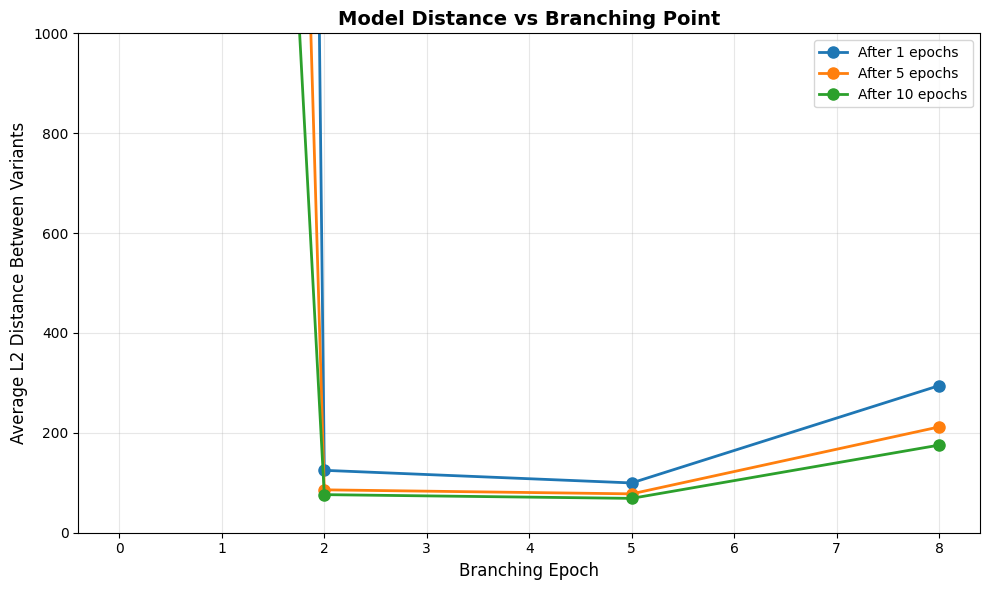

✅ Plot saved: distance_vs_branching.png


In [12]:
# Compute average L2 distance for each branching epoch and analysis epoch
avg_distances = df_distances.groupby(['branch_epoch', 'analysis_epoch'])['l2_distance'].mean().reset_index()

plt.figure(figsize=(10, 6))

for analysis_epoch in ANALYSIS_EPOCHS:
    data = avg_distances[avg_distances['analysis_epoch'] == analysis_epoch]
    plt.plot(data['branch_epoch'], data['l2_distance'],
             marker='o', linewidth=2, markersize=8,
             label=f'After {analysis_epoch} epochs')

plt.xlabel('Branching Epoch', fontsize=12)
plt.ylabel('Average L2 Distance Between Variants', fontsize=12)
plt.ylim(0,1000)
plt.title('Model Distance vs Branching Point', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "distance_vs_branching.png"), dpi=150)
plt.show()

print("✅ Plot saved: distance_vs_branching.png")

## Visualization 2: Soup Performance vs Branching Epoch

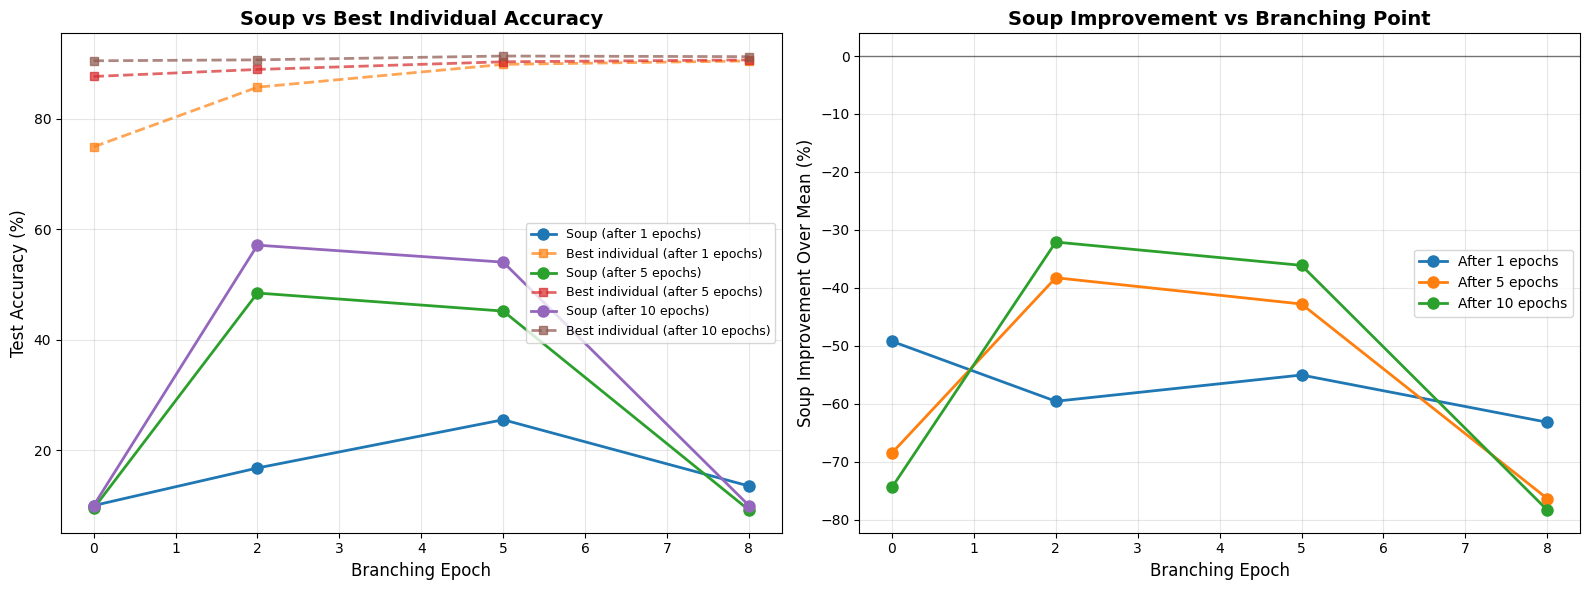

✅ Plot saved: soup_performance_vs_branching.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Soup accuracy vs branching epoch
for analysis_epoch in ANALYSIS_EPOCHS:
    data = df_soups[df_soups['analysis_epoch'] == analysis_epoch]
    axes[0].plot(data['branch_epoch'], 100*data['soup_test_acc'],
                marker='o', linewidth=2, markersize=8,
                label=f'Soup (after {analysis_epoch} epochs)')
    axes[0].plot(data['branch_epoch'], 100*data['best_individual_acc'],
                marker='s', linewidth=2, markersize=6, linestyle='--', alpha=0.7,
                label=f'Best individual (after {analysis_epoch} epochs)')

axes[0].set_xlabel('Branching Epoch', fontsize=12)
axes[0].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[0].set_title('Soup vs Best Individual Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Soup improvement over mean
for analysis_epoch in ANALYSIS_EPOCHS:
    data = df_soups[df_soups['analysis_epoch'] == analysis_epoch]
    axes[1].plot(data['branch_epoch'], 100*data['soup_improvement_over_mean'],
                marker='o', linewidth=2, markersize=8,
                label=f'After {analysis_epoch} epochs')

axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Branching Epoch', fontsize=12)
axes[1].set_ylabel('Soup Improvement Over Mean (%)', fontsize=12)
axes[1].set_title('Soup Improvement vs Branching Point', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "soup_performance_vs_branching.png"), dpi=150)
plt.show()

print("✅ Plot saved: soup_performance_vs_branching.png")

## Visualization 3: Soup Improvement vs L2 Distance

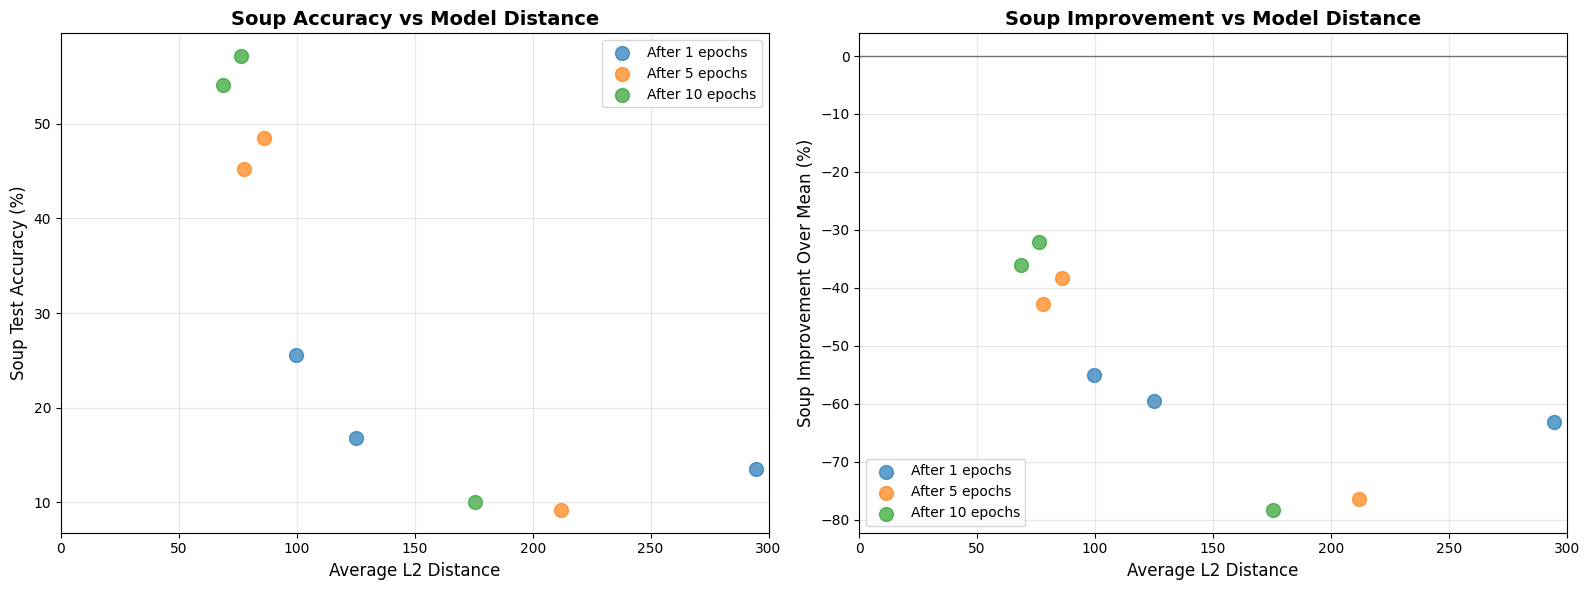

✅ Plot saved: soup_vs_distance.png


In [ ]:
# Merge soup results with average distances
df_combined = df_soups.merge(
    avg_distances,
    on=['branch_epoch', 'analysis_epoch'],
    how='left'
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Soup accuracy vs L2 distance
for analysis_epoch in ANALYSIS_EPOCHS:
    data = df_combined[df_combined['analysis_epoch'] == analysis_epoch]
    axes[0].scatter(data['l2_distance'], 100*data['soup_test_acc'],
                   s=100, alpha=0.7, label=f'After {analysis_epoch} epochs')

axes[0].set_xlabel('Average L2 Distance', fontsize=12)
axes[0].set_ylabel('Soup Test Accuracy (%)', fontsize=12)
axes[0].set_title('Soup Accuracy vs Model Distance', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Soup improvement vs L2 distance
for analysis_epoch in ANALYSIS_EPOCHS:
    data = df_combined[df_combined['analysis_epoch'] == analysis_epoch]
    axes[1].scatter(data['l2_distance'], 100*data['soup_improvement_over_mean'],
                   s=100, alpha=0.7, label=f'After {analysis_epoch} epochs')

axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Average L2 Distance', fontsize=12)
axes[1].set_ylabel('Soup Improvement Over Mean (%)', fontsize=12)
axes[1].set_title('Soup Improvement vs Model Distance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[0].set_xlim(0,300)
axes[1].set_xlim(0,300)


plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "soup_vs_distance.png"), dpi=150)
plt.show()

print("✅ Plot saved: soup_vs_distance.png")

## Summary Statistics

In [ ]:
print("\n" + "="*80)
print("SOUP ANALYSIS SUMMARY")
print("="*80)

print("\nSoup Performance by Branching Epoch:")
print("-" * 80)
summary = df_soups.groupby('branch_epoch').agg({
    'soup_test_acc': 'mean',
    'mean_individual_acc': 'mean',
    'soup_improvement_over_mean': 'mean'
})
summary['soup_test_acc'] = summary['soup_test_acc'] * 100
summary['mean_individual_acc'] = summary['mean_individual_acc'] * 100
summary['soup_improvement_over_mean'] = summary['soup_improvement_over_mean'] * 100
summary.columns = ['Soup Acc (%)', 'Mean Individual (%)', 'Improvement (%)']
print(summary.to_string())

print("\n" + "="*80)
print("HYPOTHESIS TEST: Basin Transition")
print("="*80)

early_branch = df_soups[df_soups['branch_epoch'].isin([0, 2])]['soup_improvement_over_mean'].mean()
late_branch = df_soups[df_soups['branch_epoch'].isin([5, 8])]['soup_improvement_over_mean'].mean()

print(f"\nEarly Branching (epochs 0, 2):")
print(f"  Average soup improvement: {100*early_branch:.3f}%")
print(f"\nLate Branching (epochs 5, 8):")
print(f"  Average soup improvement: {100*late_branch:.3f}%")
print(f"\nDifference: {100*(late_branch - early_branch):.3f}%")

if late_branch > early_branch:
    print("\n✅ Hypothesis SUPPORTED: Late branching shows better soup performance")
else:
    print("\n❌ Hypothesis NOT supported: Early branching shows equal or better performance")

print("="*80)


SOUP ANALYSIS SUMMARY

Soup Performance by Branching Epoch:
--------------------------------------------------------------------------------
              Soup Acc (%)  Mean Individual (%)  Improvement (%)
branch_epoch                                                    
0                 9.830000            73.878667       -64.048667
2                40.810000            84.121333       -43.311333
5                41.606667            86.260000       -44.653333
8                10.910000            83.544000       -72.634000

HYPOTHESIS TEST: Basin Transition

Early Branching (epochs 0, 2):
  Average soup improvement: -53.680%

Late Branching (epochs 5, 8):
  Average soup improvement: -58.644%

Difference: -4.964%

❌ Hypothesis NOT supported: Early branching shows equal or better performance


## Analysis Complete!

All results have been saved to the `results/` directory:
- `individual_models.csv` - Individual model performance
- `pairwise_distances.csv` - L2 distances between model pairs
- `soup_results.csv` - Soup performance metrics
- Visualization plots (PNG files)